# SECTION 2 — TREAT (6-Step Student Notebook)

This notebook matches the **6 TREAT slides** and the SEE → TREAT → VERIFY funnel.

We work with three dataframes:
- `df_raw`  → messy dataset (Global_Shipments_MESSY.csv)
- `df_clean_reference` → clean reference (Global_Shipments.csv)
- `df_treat` → your working copy that you will clean step by step

For each TREAT step:
1. We run a **step-specific check** on `df_raw`, `df_treat`, and `df_clean_reference`.
2. You implement the cleaning logic in the `# TODO` cell.
3. We re-run the check and see if `df_treat` now behaves like the reference.

Goal: By the end, all 6 step-checks pass on `df_treat` and the global KPI dashboard runs without errors.


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# FLAG: assumes both CSVs are in the same folder
df_raw = pd.read_csv('https://raw.githubusercontent.com/saikisri97/17_Hof_Lecture_Code_Pingo/refs/heads/main/Supply_Chain_Analytics/data/Global_Shipments_messy.csv')
df_clean_reference = pd.read_csv('https://raw.githubusercontent.com/saikisri97/17_Hof_Lecture_Code_Pingo/refs/heads/main/Supply_Chain_Analytics/data/Global_Shipments_v3_clean.csv')  # teacher-prepared

df_treat = df_raw.copy()
df_raw.head()


,Shipment_ID,Week,Warehouse_ID,Store_ID,Carrier,Product_Category,Weight_kg,Delivery_Time_hrs,Fuel_Price_EUR_per_litre,Temperature_C,Promo_Flag,On_Time_Flag,Weekly_Sales_EUR,Notes,Dispatch_Time,Planned_Arrival_Time,Actual_Arrival_Time
0,SH00000,2024-02-18,C,S07,C3,Frozen,19.06,29.3,1.67,2.7,0,1,64724.47,NaN,NaN,NaN,NaN
1,SH00001,2024-05-19,B,S05,C3,Grocery,10.35,30.4,1.61,2.5,0,1,61723.79,NaN,NaN,NaN,NaN
2,SH00002,2024-04-14,C,S07,C1,Clothing,14.93,34.7,1.63,NaN,1,1,54098.40,Partial delivery,NaN,NaN,NaN
3,SH00003,2024-03-17,B,S03,C3,Electronics,11.06,29.8,1.76,NaN,0,0,60609.65,Damaged carton,NaN,NaN,NaN
4,SH00004,2024-02-25,C,S12,C1,Grocery,3.41,27.3,1.69,-0.7,0,0,55689.16,NaN,NaN,NaN,NaN


## Helper Functions (do not modify)

In [80]:
def missing_report(df):
    miss_count = df.isna().sum()
    miss_pct = (df.isna().mean() * 100).round(2)
    return (
        pd.DataFrame({'Missing_Count': miss_count, 'Missing_Pct': miss_pct})
          .sort_values('Missing_Pct', ascending=False)
    )


In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_missingness_heatmap(df, title="Missingness Heatmap"):
    """
    Reusable missingness heatmap for any DataFrame.
    Use after each TREAT step to show improvements.
    """
    plt.figure(figsize=(10,5))
    sns.heatmap(df.isna(), cbar=False)
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()


In [82]:
import matplotlib.pyplot as plt

def plot_logical_status(df, col, title="Logical check"):
    """
    Shows how many values are negative, zero, and positive in a numeric column.
    Use on df_raw vs df_treat to show effect of Step 4.
    """
    series = pd.to_numeric(df[col], errors="coerce")

    counts = {
        "negative (<0)": (series < 0).sum(),
        "zero (=0)": (series == 0).sum(),
        "positive (>0)": (series > 0).sum()
    }

    plt.figure(figsize=(5,4))
    plt.bar(counts.keys(), counts.values())
    plt.title(f"{title} — {col}")
    plt.ylabel("Row count")
    plt.show()


In [83]:
def kpi_dashboard(df):
    """Global KPI dashboard used in Step 6."""
    # Critical columns used in KPIs
    assert df['Delivery_Time_hrs'].isna().sum() == 0, 'Missing Delivery_Time_hrs.'
    assert df['Weight_kg'].isna().sum() == 0, 'Missing Weight_kg.'
    assert df['Weekly_Sales_EUR'].isna().sum() == 0, 'Missing Weekly_Sales_EUR.'
    assert df['On_Time_Flag'].isna().sum() == 0, 'Missing On_Time_Flag.'

    # Type checks
    assert np.issubdtype(df['Delivery_Time_hrs'].dtype, np.number), 'Delivery_Time_hrs not numeric.'
    assert np.issubdtype(df['Weight_kg'].dtype, np.number), 'Weight_kg not numeric.'
    assert np.issubdtype(df['Weekly_Sales_EUR'].dtype, np.number), 'Weekly_Sales_EUR not numeric.'

    # Logical checks
    assert (df['Delivery_Time_hrs'] >= 0).all(), 'Negative delivery times present.'
    assert (df['Weight_kg'] > 0).all(), 'Zero/negative weights present.'

    otif = df['On_Time_Flag'].mean() * 100
    avg_delivery = df['Delivery_Time_hrs'].mean()
    avg_rev_per_kg = (df['Weekly_Sales_EUR'] / df['Weight_kg']).mean()

    print('--- KPI DASHBOARD ---')
    print(f'On-Time Delivery (OTIF): {otif:.1f}%')
    print(f'Average Delivery Time (hrs): {avg_delivery:.2f}')
    print(f'Average Revenue per kg (EUR/kg): {avg_rev_per_kg:.2f}')


In [84]:
def step1_check_missing_notes(df):
    assert df['Notes'].isna().sum() == 0, 'Notes still missing.'
    print('Notes OK (no missing).')


In [85]:
def step2_check_dtypes(df):
    numeric_cols = ['Weight_kg', 'Delivery_Time_hrs', 'Fuel_Price_EUR_per_litre',
                    'Weekly_Sales_EUR', 'Temperature_C']
    for col in numeric_cols:
        assert np.issubdtype(df[col].dtype, np.number), f'{col} is not numeric.'
    # Flags
    assert str(df['Promo_Flag'].dtype).startswith('int'), 'Promo_Flag not integer.'
    assert str(df['On_Time_Flag'].dtype).startswith('int'), 'On_Time_Flag not integer.'
    print('Data types for numeric and flag fields are correct.')


In [86]:
def step3_check_numeric_missing(df):
    cols = ['Weight_kg', 'Delivery_Time_hrs', 'Fuel_Price_EUR_per_litre',
            'Weekly_Sales_EUR', 'Temperature_C']
    missing = df[cols].isna().sum()
    assert missing.sum() == 0, f'Missing values remain in numeric cols:\n{missing}'
    print('Numeric missing values handled for key columns.')


In [87]:
def step4_check_logical(df):
    # Ensure numeric before logical comparison
    try:
        cond1 = (df['Delivery_Time_hrs'] >= 0)
        cond2 = (df['Weight_kg'] > 0)
    except TypeError:
        raise AssertionError(
            "Logical check failed because columns are not numeric yet — "
            "complete Step 2 (data types) and Step 3 (numeric missing) first."
        )

    assert cond1.all(), 'Negative delivery times present.'
    assert cond2.all(), 'Zero/negative weights present.'
    print('Logical checks passed: no negative times and no non-positive weights.')


In [88]:
def step5_check_outliers(df, ref):
    """
    Pure check function for compare_step() — NO PLOTS HERE.
    """

    # Safe conversion
    try:
        numeric = pd.to_numeric(df['Delivery_Time_hrs'], errors='raise')
    except Exception:
        raise AssertionError(
            "Delivery_Time_hrs contains non-numeric values — complete Step 2 & 3 first."
        )

    raw_max = numeric.max()
    ref_max = ref['Delivery_Time_hrs'].max()

    if raw_max > ref_max * 1.5:
        raise AssertionError(
            f"Delivery_Time_hrs max ({raw_max}) too large vs reference ({ref_max})."
        )

    print("Outlier check passed.")


In [89]:
def compare_step(step_name, check_func, df_raw, df_treat, df_ref, needs_ref=False):
    print(f'=== {step_name} ===')
    for label, frame in [('RAW', df_raw), ('TREAT', df_treat), ('CLEAN_REF', df_ref)]:
        print(f'-- {label} --')
        try:
            if needs_ref:
                check_func(frame, df_ref)
            else:
                check_func(frame)
        except AssertionError as e:
            print(f'❌ FAILED: {e}')
        else:
            print('✅ PASSED')
        print()


## STEP 1 — Fix Non-Critical Missing (`Notes`)
Slide: **TREAT Step 1 — Handling Missing Values (Non-Critical)**

Goal: No missing values in `Notes`.

### 1A. Check RAW vs TREAT vs CLEAN_REF


In [90]:
compare_step('STEP 1 — Missing Notes', step1_check_missing_notes,
             df_raw, df_treat, df_clean_reference)


=== STEP 1 — Missing Notes ===
-- RAW --
❌ FAILED: Notes still missing.

-- TREAT --
❌ FAILED: Notes still missing.

-- CLEAN_REF --
Notes OK (no missing).
✅ PASSED



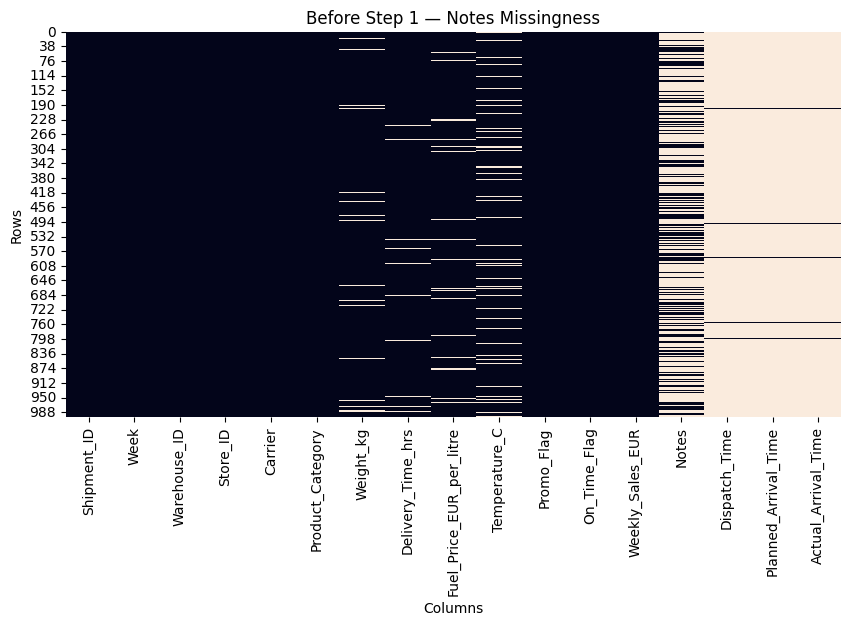

In [91]:
plot_missingness_heatmap(df_treat, "Before Step 1 — Notes Missingness")


### 1B. TODO: Implement the fix on `df_treat`
**Hint (Python):** `df_treat['Notes'] = df_treat['Notes'].fillna('No issue')`


In [92]:
# TODO: Fill missing Notes in df_treat with 'No issue'
# df_treat['Notes'] = ...


### 1C. Re-check STEP 1 on df_treat

In [93]:
compare_step('STEP 1 — Missing Notes (after TREAT)', step1_check_missing_notes,
             df_raw, df_treat, df_clean_reference)


=== STEP 1 — Missing Notes (after TREAT) ===
-- RAW --
❌ FAILED: Notes still missing.

-- TREAT --
❌ FAILED: Notes still missing.

-- CLEAN_REF --
Notes OK (no missing).
✅ PASSED



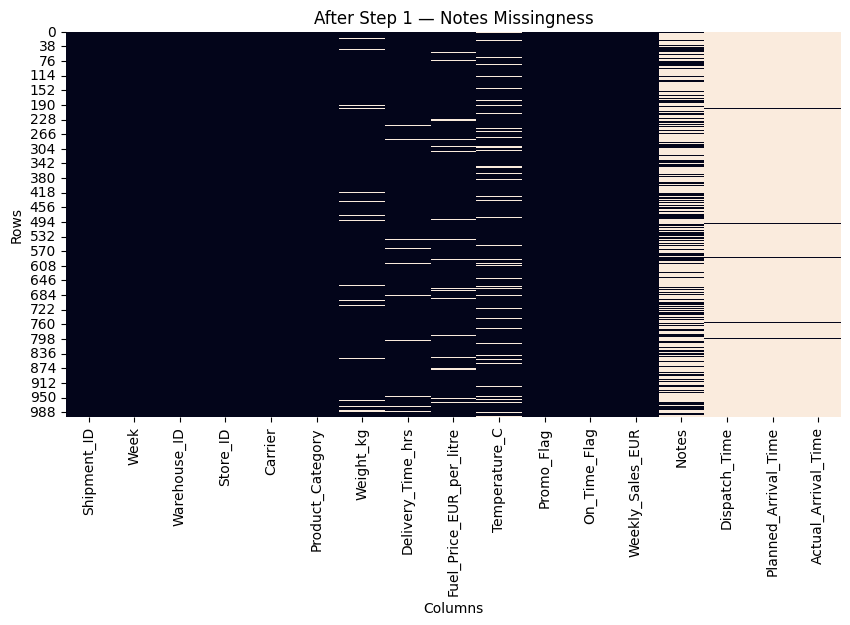

In [94]:
plot_missingness_heatmap(df_treat, "After Step 1 — Notes Missingness")


## STEP 2 — Fix Data Types
Slide: **TREAT Step 2 — Data Type Corrections**

Goal: Numeric columns truly numeric, flags integer.

### 2A. Check RAW vs TREAT vs CLEAN_REF


In [95]:
compare_step('STEP 2 — Data Types', step2_check_dtypes,
             df_raw, df_treat, df_clean_reference)


=== STEP 2 — Data Types ===
-- RAW --
❌ FAILED: Weight_kg is not numeric.

-- TREAT --
❌ FAILED: Weight_kg is not numeric.

-- CLEAN_REF --
Data types for numeric and flag fields are correct.
✅ PASSED



### 2B. TODO: Correct Data Types on `df_treat`
**Hints (Python):**
- `pd.to_numeric(df_treat[col], errors='coerce')`



In [96]:
# TODO: Correct data types in df_treat
numeric_cols = [''] # check for the column which are not numeric -see the error message for which column to fix 
for col in numeric_cols:
    df_treat[col] = pd.to_numeric(df_treat[col], errors='coerce')


df_treat['On_Time_Flag'] = df_treat['On_Time_Flag'].astype('')# complete this 'int64' or 'float64' ? 

KeyError: ''

### 2C. Re-check STEP 2 on df_treat

In [97]:
compare_step('STEP 2 — Data Types (after TREAT)', step2_check_dtypes,
             df_raw, df_treat, df_clean_reference)


=== STEP 2 — Data Types (after TREAT) ===
-- RAW --
❌ FAILED: Weight_kg is not numeric.

-- TREAT --
❌ FAILED: Weight_kg is not numeric.

-- CLEAN_REF --
Data types for numeric and flag fields are correct.
✅ PASSED



## STEP 3 — Fix Numeric Missing (Key KPI Fields)
Slide: **TREAT Step 3 — Handling Missing Values (Critical Numerics)**

Goal: No missing values in:
- Weight_kg, Delivery_Time_hrs, Fuel_Price_EUR_per_litre,
- Weekly_Sales_EUR, Temperature_C

### 3A. Check RAW vs TREAT vs CLEAN_REF


In [98]:
compare_step('STEP 3 — Numeric Missing', step3_check_numeric_missing,
             df_raw, df_treat, df_clean_reference)


=== STEP 3 — Numeric Missing ===
-- RAW --
❌ FAILED: Missing values remain in numeric cols:
Weight_kg                    38
Delivery_Time_hrs            26
Fuel_Price_EUR_per_litre     50
Weekly_Sales_EUR              0
Temperature_C               106
dtype: int64

-- TREAT --
❌ FAILED: Missing values remain in numeric cols:
Weight_kg                    38
Delivery_Time_hrs            26
Fuel_Price_EUR_per_litre     50
Weekly_Sales_EUR              0
Temperature_C               106
dtype: int64

-- CLEAN_REF --
Numeric missing values handled for key columns.
✅ PASSED



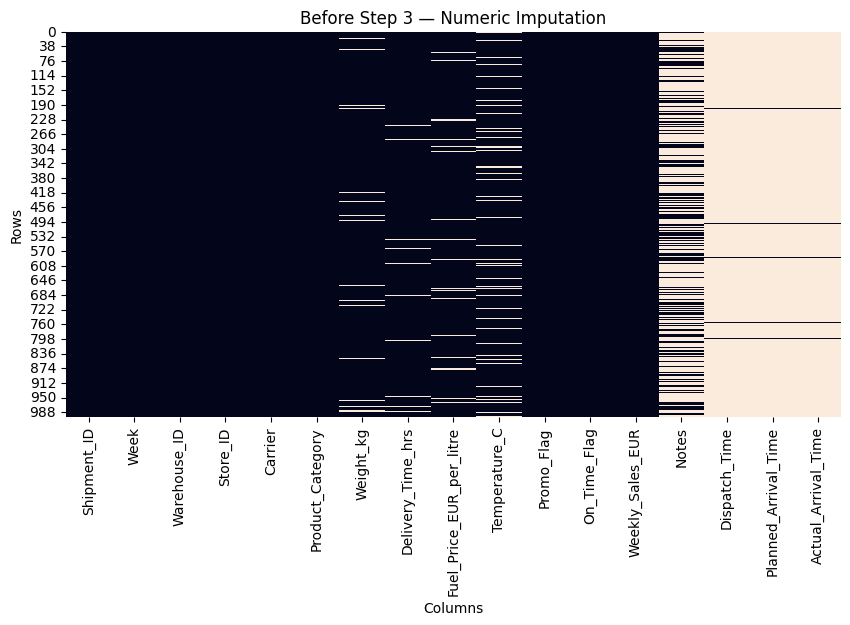

In [99]:
plot_missingness_heatmap(df_treat, "Before Step 3 — Numeric Imputation")


### 3B. TODO: Impute Numeric Fields on `df_treat`
**Hints (Python):**
- `df_treat.groupby('Product_Category')['Weight_kg'].transform(lambda s: s.fillna(s.median()))`
- `df_treat[col] = df_treat[col].fillna(df_treat[col]."give the right Impute strategy here"())`


In [100]:
# TODO: Impute numeric fields in df_treat
df_treat['Weight_kg'] = 
for col in ['Delivery_Time_hrs', 'Fuel_Price_EUR_per_litre', 'Weekly_Sales_EUR', 'Temperature_C']:
    df_treat[col] = df_treat[col].fillna(df_treat[col].)# think about is it better with .median() or mean ( )


SyntaxError: invalid syntax (96096479.py, line 2)

### 3C. Re-check STEP 3 on df_treat

In [101]:
compare_step('STEP 3 — Numeric Missing (after TREAT)', step3_check_numeric_missing,
             df_raw, df_treat, df_clean_reference)


=== STEP 3 — Numeric Missing (after TREAT) ===
-- RAW --
❌ FAILED: Missing values remain in numeric cols:
Weight_kg                    38
Delivery_Time_hrs            26
Fuel_Price_EUR_per_litre     50
Weekly_Sales_EUR              0
Temperature_C               106
dtype: int64

-- TREAT --
❌ FAILED: Missing values remain in numeric cols:
Weight_kg                    38
Delivery_Time_hrs            26
Fuel_Price_EUR_per_litre     50
Weekly_Sales_EUR              0
Temperature_C               106
dtype: int64

-- CLEAN_REF --
Numeric missing values handled for key columns.
✅ PASSED



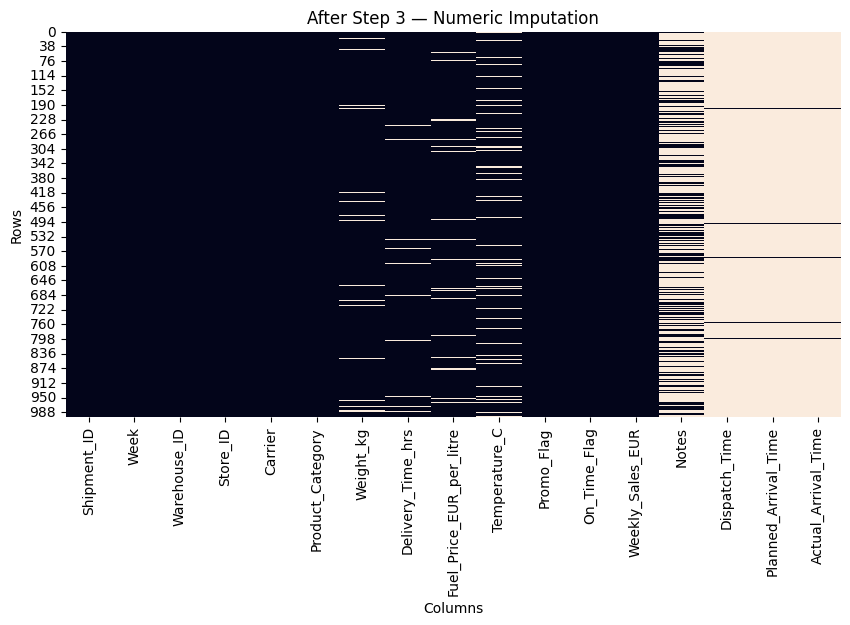

In [102]:
plot_missingness_heatmap(df_treat, "After Step 3 — Numeric Imputation")


## STEP 4 — Logical Cleaning (Impossible Values)
Slide: **TREAT Step 4 — Cleaning Logical Errors**

Goal: No negative delivery times and no zero/negative weights.

### 4A. Check RAW vs TREAT vs CLEAN_REF


In [103]:
compare_step('STEP 4 — Logical Checks', step4_check_logical,
             df_raw, df_treat, df_clean_reference)


=== STEP 4 — Logical Checks ===
-- RAW --
❌ FAILED: Logical check failed because columns are not numeric yet — complete Step 2 (data types) and Step 3 (numeric missing) first.

-- TREAT --
❌ FAILED: Logical check failed because columns are not numeric yet — complete Step 2 (data types) and Step 3 (numeric missing) first.

-- CLEAN_REF --
Logical checks passed: no negative times and no non-positive weights.
✅ PASSED



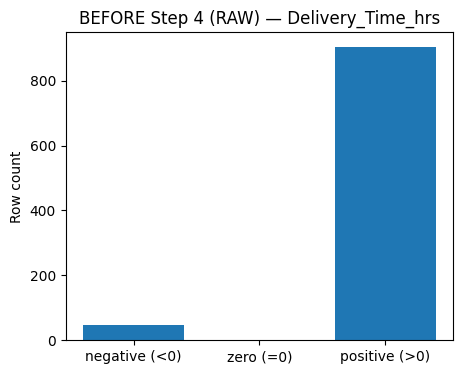

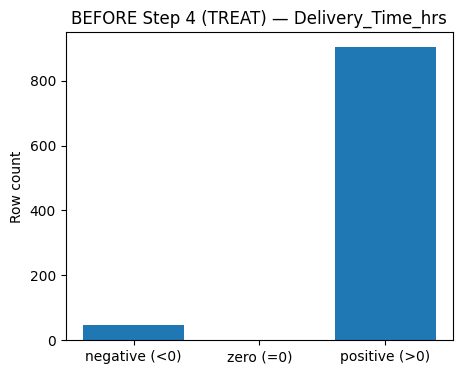

In [104]:
plot_logical_status(df_raw, "Delivery_Time_hrs", title="BEFORE Step 4 (RAW)")
plot_logical_status(df_treat, "Delivery_Time_hrs", title="BEFORE Step 4 (TREAT)")


### 4B. TODO: Fix Logical Errors on `df_treat`
**Hints (Python):**
- First turn the impossible values in NaN
- `df_treat.loc[df_treat['Delivery_Time_hrs'] < 0, 'Delivery_Time_hrs'] = np.nan`
- `df_treat.loc[df_treat['Weight_kg'] <= 0, 'Weight_kg'] = np.nan`
- then think about what to do if you have NaN


In [105]:
# TODO: Clean logical errors in df_treat
df_treat.loc[df_treat['Delivery_Time_hrs'] < 0, 'Delivery_Time_hrs'] = np.nan



TypeError: '<' not supported between instances of 'str' and 'int'

In [106]:
# Re-impute numeric cols after turning bad values into NaN
for col in ['', '']: # think about which column have to be re imputed because of NaN values in the previous step
    df_treat[col] = df_treat[col].fillna(df_treat[col].median())


KeyError: ''

### 4C. Re-check STEP 4 on df_treat

In [107]:
compare_step('STEP 4 — Logical Checks (after TREAT)', step4_check_logical,
             df_raw, df_treat, df_clean_reference)


=== STEP 4 — Logical Checks (after TREAT) ===
-- RAW --
❌ FAILED: Logical check failed because columns are not numeric yet — complete Step 2 (data types) and Step 3 (numeric missing) first.

-- TREAT --
❌ FAILED: Logical check failed because columns are not numeric yet — complete Step 2 (data types) and Step 3 (numeric missing) first.

-- CLEAN_REF --
Logical checks passed: no negative times and no non-positive weights.
✅ PASSED



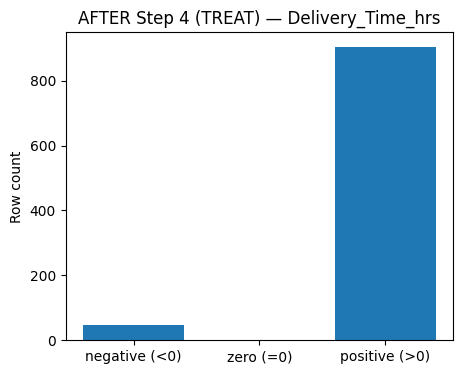

In [109]:
plot_logical_status(df_treat, "Delivery_Time_hrs", title="AFTER Step 4 (TREAT)")



## STEP 5 — Outlier Handling (`Delivery_Time_hrs`)
Slide: **TREAT Step 5 — Outlier Treatment**

Goal: Delivery_Time_hrs not wildly beyond reference.

### 5A. Check RAW vs TREAT vs CLEAN_REF


In [110]:
## this is an helper function to plot the box plot to see the outliers
def step5_plot_treat(df_treat):
    numeric = pd.to_numeric(df_treat['Delivery_Time_hrs'], errors='coerce')

    plt.figure(figsize=(4,6))
    plt.boxplot(numeric.dropna(), vert=True, patch_artist=True)
    plt.title("Boxplot — Delivery_Time_hrs (TREAT)")
    plt.ylabel("Hours")
    plt.show()


In [111]:
compare_step('STEP 5 — Outliers', step5_check_outliers,
             df_raw, df_treat, df_clean_reference, needs_ref=True)


=== STEP 5 — Outliers ===
-- RAW --
❌ FAILED: Delivery_Time_hrs contains non-numeric values — complete Step 2 & 3 first.

-- TREAT --
❌ FAILED: Delivery_Time_hrs contains non-numeric values — complete Step 2 & 3 first.

-- CLEAN_REF --
Outlier check passed.
✅ PASSED



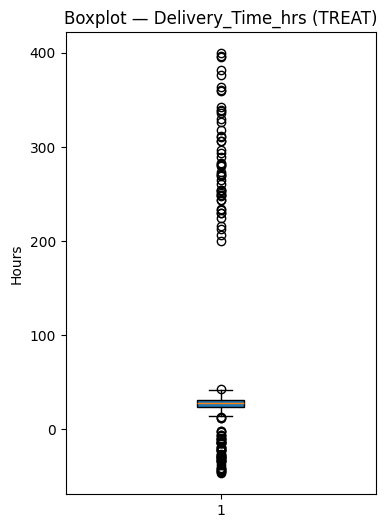

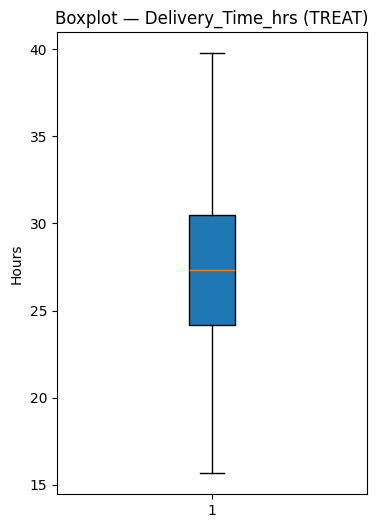

In [112]:
step5_plot_treat(df_treat)
step5_plot_treat(df_clean_reference)


### 5B. TODO: Treat Outliers on `df_treat`
**Hints (Python):**
- Compute IQR on Delivery_Time_hrs - for upper bound use function df['col'].quantile(percentile)
- Define lower/upper bounds  - lower bound is q1 - 1.5 times of Inter Quartile Range
- Use `.clip(lower=..., upper=...)`


In [ ]:
# TODO: Treat outliers in Delivery_Time_hrs in df_treat
q1 = df_treat['Delivery_Time_hrs'].quantile(0.25)
q3 = df_treat['Delivery_Time_hrs'] # calculate 75th percentile
iqr = q3 - q1
lower_bound = # calculate lower bound 
upper_bound = q3 + 1.5 * iqr
df_treat['Delivery_Time_hrs'] = df_treat['Delivery_Time_hrs'].clip(lower=lower_bound, upper=upper_bound)


TypeError: unsupported operand type(s) for -: 'str' and 'str'

### 5C. Re-check STEP 5 on df_treat

In [114]:
compare_step('STEP 5 — Outliers (after TREAT)', step5_check_outliers,
             df_raw, df_treat, df_clean_reference, needs_ref=True)


=== STEP 5 — Outliers (after TREAT) ===
-- RAW --
❌ FAILED: Delivery_Time_hrs contains non-numeric values — complete Step 2 & 3 first.

-- TREAT --
❌ FAILED: Delivery_Time_hrs contains non-numeric values — complete Step 2 & 3 first.

-- CLEAN_REF --
Outlier check passed.
✅ PASSED



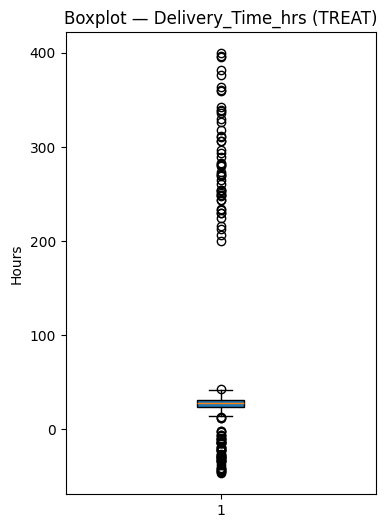

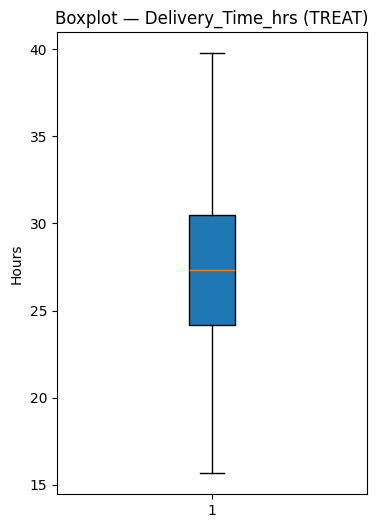

In [115]:
step5_plot_treat(df_treat)
step5_plot_treat(df_clean_reference)


## STEP 6 — Global KPI Dashboard (TREAT Complete)
Slide: **TREAT Step 6 — KPI Readiness & Summary**

Now we run the global KPI dashboard on RAW, TREAT, and CLEAN_REF.


In [116]:
print('--- RAW ---')
try:
    kpi_dashboard(df_raw)
except AssertionError as e:
    print(f'❌ RAW FAILED: {e}')

print('\n--- TREAT (your cleaned data) ---')
try:
    kpi_dashboard(df_treat)
except AssertionError as e:
    print(f'❌ TREAT FAILED: {e}')

print('\n--- CLEAN_REF (teacher reference) ---')
kpi_dashboard(df_clean_reference)


--- RAW ---
❌ RAW FAILED: Missing Delivery_Time_hrs.

--- TREAT (your cleaned data) ---
❌ TREAT FAILED: Missing Delivery_Time_hrs.

--- CLEAN_REF (teacher reference) ---
--- KPI DASHBOARD ---
On-Time Delivery (OTIF): 13.0%
Average Delivery Time (hrs): 27.27
Average Revenue per kg (EUR/kg): 4583.64
